#Upload Data


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import files
from google.colab import drive
import pathlib

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 27 14:34:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def upload_drive():
  drive.mount('/content/drive')

In [ ]:
upload_drive()

Mounted at /content/drive


In [ ]:
import shutil
shutil.copy("/content/drive/My Drive/AARD/idb1.zip", "idb1.zip")

'idb1.zip'

In [ ]:
!ls

drive  idb1.zip  sample_data


In [ ]:
!unzip idb1.zip

In [ ]:
!rm -rf __MACOSX/
!mkdir -p idb1small/ds/neg
!mkdir -p idb1small/ds/pos

#Resize the image

In [ ]:
TARGET_RATIO = 4/3
TARGET_WIDTH = 1200
TARGET_HEIGHT = int(TARGET_WIDTH/TARGET_RATIO)

def resize_image(img, tw=TARGET_WIDTH, th=TARGET_HEIGHT): 
    w, h = img.size[0], img.size[1] 
    dw, dh = 0, 0 
    tr = tw / th 
    if w / h > tr: 
        dw = w - h * tr 
    elif w / h < tr: 
        dh = h - w / tr 
    if dw > 0 or dh > 0: 
        img = img.crop((dw//2, dh // 2, w - dw // 2, h - dh // 2))

    return img.resize((tw, th))

def resize_all_images(from_dir: str, to_dir: str, width: int, height: int): 
    """Resize all images from one directory and put result in another. 
       neg and pos should be the child directories of input dir. 
    """
    src_dir = pathlib.Path(from_dir)
    tgt_dir = pathlib.Path(to_dir) 
    for src_img_path in src_dir.glob('*/*.jpg'): 
        print(f"Resize image: {src_img_path}") 
        img = tf.keras.utils.load_img(src_img_path) 
        resized_img = resize_image(img, tw=width, th=height) 
        tgt_img_path = (str(src_img_path)).replace(from_dir, to_dir) 
        resized_img.save(tgt_img_path)
        print(f"Image {src_img_path} is resized as {tgt_img_path} to size {width}/{height}")

In [ ]:
resize_all_images('idb1/ds', 'idb1small/ds', TARGET_WIDTH, TARGET_HEIGHT)

In [ ]:
data_dir = pathlib.Path('idb1small/ds')
image_count = len(list(data_dir.glob('*/*.jpg'))) 
print(image_count)
list(data_dir.glob('*/*.jpg'))[:10]

#Select test files

In [ ]:
!mkdir -p test_data/neg
!mkdir -p test_data/pos

In [ ]:
# Copy back test files back to source
def move_back_test_files(src_dir: str, test_dir: str):
    img_files = [str(p) for p in pathlib.Path(test_dir).glob('*/*.jpg')]
    for f in img_files:
        nf = str(f).replace(test_dir, src_dir)
        print(f"Move file {f} to {nf}")
        pathlib.Path(f).rename(nf)


# Pick test files and move out.
def move_out_test_files(src_dir: str, test_dir: str, test_ratio=0.15):
    src_files = [str(p) for p in pathlib.Path(src_dir).glob('*/*.jpg')]
    total = len(src_files)
    dist_indices = np.arange(total)
    np.random.shuffle(dist_indices)

    test_count = int(total * test_ratio)
    test_files = [src_files[dist_indices[i]] for i in range(test_count)]
    
    # move 
    for name in test_files:
        tf = pathlib.Path(name)
        test_loc = str(tf).replace(src_dir, test_dir)
        print(f"Move file from {str(tf)} to {test_loc}")
        tf.rename(test_loc)

In [ ]:
!ls idb1small

ds


In [ ]:
move_out_test_files('idb1small/ds', 'test_data')

In [ ]:
test_dir = pathlib.Path('test_data')
test_files = list(test_dir.glob('*/*.jpg')) 

for img in test_files:
  print(img)

# Create a dataset


In [ ]:
batch_size = 32
img_height = TARGET_HEIGHT
img_width = TARGET_WIDTH

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 108 files belonging to 2 classes.
Using 87 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 108 files belonging to 2 classes.
Using 21 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['neg', 'pos']


#Visualize Data

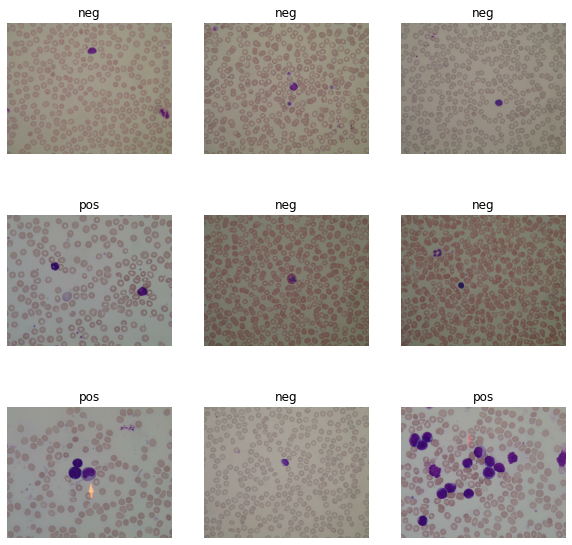

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 960, 1200, 3)
(32,)


#Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

#Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.5, seed=42),
    layers.RandomZoom((0.1,0.3)),
  ]
)

In [ ]:
img_height, img_width

(900, 1200)

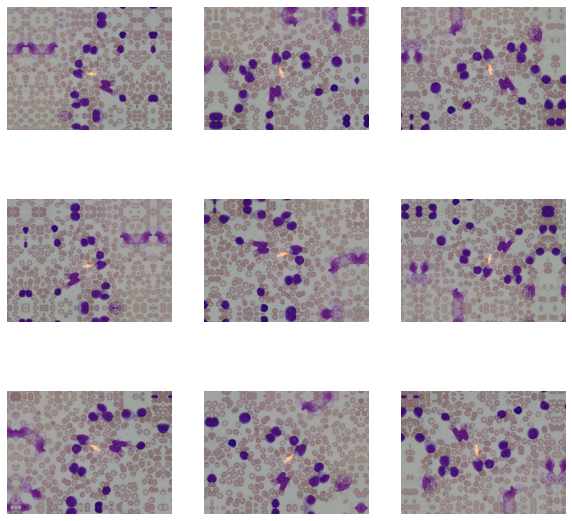

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_images = data_augmentation(images)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#Dropout

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

#Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 900, 1200, 3)      0         
                                                                 
 rescaling_5 (Rescaling)     (None, 900, 1200, 3)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 900, 1200, 16)     448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 450, 600, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 450, 600, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 225, 300, 32)     0         
 g2D)                                                 

In [ ]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
3/3 [==============================] - 16s 6s/step - loss: 48.8199 - accuracy: 0.5541 - val_loss: 18.3985 - val_accuracy: 0.5000
Epoch 2/40
3/3 [==============================] - 14s 4s/step - loss: 14.5086 - accuracy: 0.4189 - val_loss: 2.1813 - val_accuracy: 0.5000
Epoch 3/40
3/3 [==============================] - 14s 4s/step - loss: 2.2190 - accuracy: 0.5405 - val_loss: 0.8661 - val_accuracy: 0.5000
Epoch 4/40
3/3 [==============================] - 14s 4s/step - loss: 1.0518 - accuracy: 0.4595 - val_loss: 0.6462 - val_accuracy: 0.6667
Epoch 5/40
3/3 [==============================] - 14s 4s/step - loss: 0.6829 - accuracy: 0.5811 - val_loss: 0.7444 - val_accuracy: 0.5000
Epoch 6/40
3/3 [==============================] - 14s 4s/step - loss: 0.7061 - accuracy: 0.5000 - val_loss: 0.6446 - val_accuracy: 0.6667
Epoch 7/40
3/3 [==============================] - 14s 4s/step - loss: 0.6449 - accuracy: 0.7432 - val_loss: 0.6190 - val_accuracy: 0.6667
Epoch 8/40
3/3 [===============

#Visualize training results

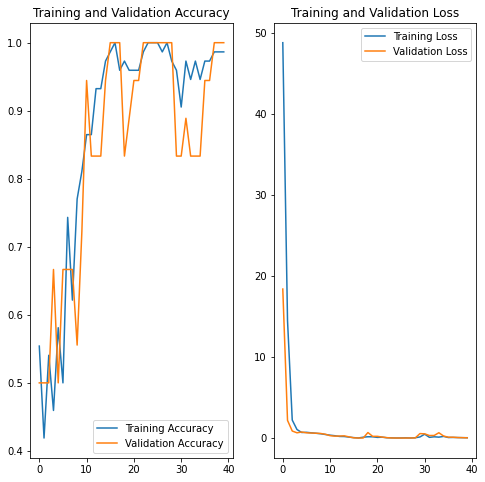

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Save the model

In [ ]:
!mkdir -p saved_model
model.save('saved_model/all_model1')

In [ ]:
# upload the model
new_model = tf.keras.models.load_model('saved_model/all_model1')

# Check its architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 900, 1200, 3)      0         
                                                                 
 rescaling_5 (Rescaling)     (None, 900, 1200, 3)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 900, 1200, 16)     448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 450, 600, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 450, 600, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 225, 300, 32)     0         
 g2D)                                                 

#Save model to drive

In [ ]:
new_model.save('/content/drive/My Drive/AARD/Saved_Models/all_model1')

In [ ]:
drive.flush_and_unmount()

In [ ]:
upload_drive()

In [ ]:
# upload the model
new_model = tf.keras.models.load_model('/content/drive/My Drive/AARD/Saved_Models/all_model1')

# Check its architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 900, 1200, 3)      0         
                                                                 
 rescaling_5 (Rescaling)     (None, 900, 1200, 3)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 900, 1200, 16)     448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 450, 600, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 450, 600, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 225, 300, 32)     0         
 g2D)                                                 